In [ ]:
from fastcore.test import *

from execnb.shell import CaptureShell

### Streams preserve newlines

In [ ]:
# TODO: Add a `raise` arg to `run`?

In [ ]:
k = CaptureShell()
res = k.run(r"print('a\nb'); print('c\n\n'); print('d')")
test_eq(res, [{'name': 'stdout', 'output_type': 'stream', 'text': ['a\n', 'b\n', 'c\n', '\n', '\n', 'd\n']}])

### Trailing semicolon silences output

In [ ]:
test_eq(CaptureShell().run('0;'), [])

### Binary `PILImage`s are consistent (base64 encoded and stringified)

In [ ]:
# TODO: create an image programmatically?

In [ ]:
def pilimg2b64(img): return b64encode(img._repr_png_()).decode()+'\n'

In [ ]:
from base64 import b64encode
from fastai.vision.core import PILImage

TEST_IMAGE = 'images/puppy.jpg'
img = PILImage.create(TEST_IMAGE)
res = CaptureShell().run(f'from fastai.vision.core import PILImage; PILImage.create("{TEST_IMAGE}")')
test_eq(res[0]['data']['image/png'], pilimg2b64(img))

### `PIL.Image.Image`s are consistent

In [ ]:
from base64 import b64encode
from fastai.vision.core import PILImage

imr = img.resize((64,64))
res = CaptureShell().run(f'from fastai.vision.core import PILImage; PILImage.create("{TEST_IMAGE}").resize((64,64))')
test_eq(res[0]['data']['image/png'], pilimg2b64(imr))

In [ ]:
import PIL
from io import BytesIO
from base64 import b64decode

def str2img(s): return PIL.Image.open(BytesIO(b64decode(s)))

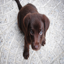

In [ ]:
str2img(res[0]['data']['image/png'])

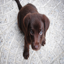

In [ ]:
imr

### Matplotlib inline works from inside a notebook

In [ ]:
import matplotlib

backend = matplotlib.get_backend()
matplotlib.use('module://matplotlib_inline.backend_inline')

res = CaptureShell().run('import matplotlib.pyplot as plt; plt.plot([0,1]);')
assert isinstance(res[0]['data'].get('image/png', None), str)

matplotlib.use(backend)

### Matplotlib images are consistent

In [ ]:
def fig2str(fig=None):
    if fig is None: fig = plt
    b = BytesIO()
    fig.savefig(b, format='png', bbox_inches='tight')
    b.seek(0)
    return b64encode(b.read()).decode()+'\n'

In [ ]:
import matplotlib.pyplot as plt

res = CaptureShell().run('import matplotlib.pyplot as plt; plt.plot([0,1]);')
xs = res[0]['data']['image/png']

plt.plot([0,1])
ys = fig2str()
plt.close()

test_eq(xs, ys)

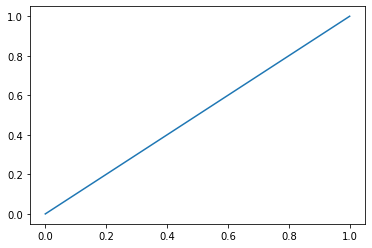

In [ ]:
str2img(xs)

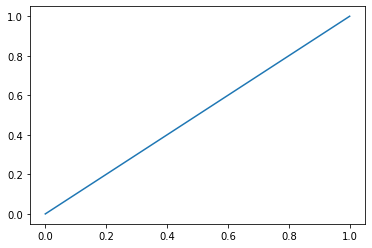

In [ ]:
str2img(ys)

In [ ]:
res = CaptureShell().run('''
import matplotlib.pyplot as plt
from fastcore.transform import Transform
from fastai.data.external import untar_data, URLs
from fastai.data.transforms import get_image_files
from fastai.vision.core import PILImage, PILMask

camvid = untar_data(URLs.CAMVID_TINY)
fns = get_image_files(camvid/'images')
cam_fn = fns[0]
mask_fn = camvid/'labels'/f'{cam_fn.stem}_P{cam_fn.suffix}'

cam_img = PILImage.create(cam_fn)
tmask = Transform(PILMask.create)
mask = tmask(mask_fn)

fig,axs = plt.subplots(1,3, figsize=(12,3))
cam_img.show(ctx=axs[0], title='image')
mask.show(alpha=1, ctx=axs[1], vmin=1, vmax=30, title='mask')
cam_img.show(ctx=axs[2], title='superimposed')
mask.show(ctx=axs[2], vmin=1, vmax=30);
''')
xs = res[0]['data']['image/png']

In [ ]:
from fastcore.transform import Transform
from fastai.data.external import untar_data, URLs
from fastai.data.transforms import get_image_files
from fastai.vision.core import PILImage, PILMask

camvid = untar_data(URLs.CAMVID_TINY)
fns = get_image_files(camvid/'images')
cam_fn = fns[0]
mask_fn = camvid/'labels'/f'{cam_fn.stem}_P{cam_fn.suffix}'

cam_img = PILImage.create(cam_fn)
tmask = Transform(PILMask.create)
mask = tmask(mask_fn)

fig,axs = plt.subplots(1,3, figsize=(12,3))
cam_img.show(ctx=axs[0], title='image')
mask.show(alpha=1, ctx=axs[1], vmin=1, vmax=30, title='mask')
cam_img.show(ctx=axs[2], title='superimposed')
mask.show(ctx=axs[2], vmin=1, vmax=30);

In [ ]:
ys = fig2str(fig)

In [ ]:
test_eq(xs, ys)

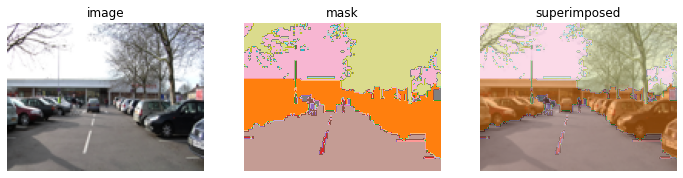

In [ ]:
str2img(xs)

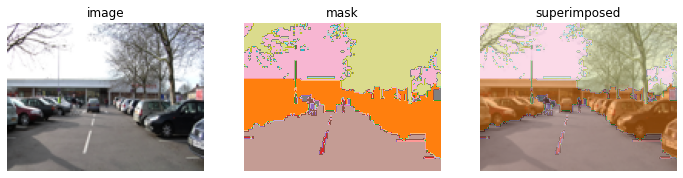

In [ ]:
str2img(ys)

In [ ]:
im = PILImage.create(TEST_IMAGE)

### Standard error (stderr) is captured

In [ ]:
res = CaptureShell().run("import sys; sys.stderr.write('Error!');")
test_eq(res, [{'name': 'stderr', 'output_type': 'stream', 'text': ['Error!']}])

### Streams are ordered correctly

In [ ]:
# `display_data` flushes stdout and stderr (in that order)
res = CaptureShell().run('''
import sys
sys.stderr.write('Error!')
print(1)
display(1)''')
test_eq(res, [{'name': 'stdout', 'output_type': 'stream', 'text': ['1\n']},
              {'name': 'stderr', 'output_type': 'stream', 'text': ['Error!']},
              {'data': {'text/plain': ['1']}, 'metadata': {}, 'output_type': 'display_data'}])

In [ ]:
# Consecutive writes to stdout are grouped
res = CaptureShell().run('''
print(1)
print(2)
print(3)''')
test_eq(res, [{'name': 'stdout', 'output_type': 'stream', 'text': ['1\n', '2\n', '3\n']}])

In [ ]:
# Consecutive writes to stdout are grouped despite an intermediate write to stderr, which is captured after
res = CaptureShell().run('''
import sys
print(1)
print(2)
sys.stderr.write('Error!')
print(3)''')
test_eq(res, [{'name': 'stdout', 'output_type': 'stream', 'text': ['1\n', '2\n', '3\n']},
              {'name': 'stderr', 'output_type': 'stream', 'text': ['Error!']}])

In [ ]:
# `execute_result` is always at the end
res = CaptureShell().run('''
import sys
sys.stderr.write('Error!')
print(1)
display(1)
1''')
test_eq(res, [{'name': 'stdout', 'output_type': 'stream', 'text': ['1\n']},
              {'name': 'stderr', 'output_type': 'stream', 'text': ['Error!']},
              {'data': {'text/plain': ['1']}, 'metadata': {}, 'output_type': 'display_data'},
              {'data': {'text/plain': ['1']}, 'metadata': {}, 'output_type': 'execute_result', 'execution_count': 1}])